# Experiments on real world datasets

This notebook shows the experiments in the Chapter 3 of the thesis.

## 1. Import libraries

In [1]:
import sys
sys.path.insert(1, r'..\\src')

# python package with the FRU measure
import fairfru

# data manipulation
import numpy as np
import pandas as pd
import os
from copy import deepcopy
import pickle
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from matplotlib import colors
from sklearn.model_selection import train_test_split

# fairness measures
from aif360.sklearn.metrics import statistical_parity_difference, disparate_impact_ratio, equal_opportunity_difference,average_odds_difference, kl_divergence

# custom functions
from utils import train_classifier_predict, CDD_difference
from preprocessing.preprocess_data import preprocess_datasets

# paths
dataset_path = r'..\\data\\raw'
filepath = r"..\\results\\figures\\FRU"
logpath = r"..\\results\\logs\\FRU"

# random states to create data samples
np.random.seed(42)
random_states = np.random.randint(0,1000,5) 

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


In [2]:
sns.set()
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context(font_scale=1.4) # , rc=paper_rc, 'paper'

font = {'family' : 'Times New Roman',
        'size'   : 18}
plt.rc('font', **font)

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## 2. Compute FRU & create figures

In [9]:
# choose dataset
datasets = ['german.data', 'BROWARD_CLEAN.csv', 'titanic.csv', 'diabetes.csv', 'bank_r.csv',
            'adult.data', 'lawschool.csv', 'acsincome.pkl', 'acspubliccoverage.pkl', 
            'acsemployment.pkl']
dataset = 'german.data'

# load dataset
df, df_num, metadata, num, binarized_prot  = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

# choose features for which the FRU will be computed, all but the target feature
features = [col for col in df.columns if col != metadata['target']]

# create a folder name to save the membership values to the fuzzy rough regions
folder_name = metadata['dataset_name']+'_sample' # 
path = os.path.join(logpath, folder_name)
if not os.path.exists(path):
    os.makedirs(os.path.join(path))

Compute the FRU values for all features using five slightly different versions of the dataset to account for the robustness of our method through small variations of the data. For a closer look at how the fairfru package works, please refer to the example in the related repository https://github.com/LisaKouts/FRUBias. The membership values are saves as pickle files in `\results\figures\FRU\german_sample`.

In [ ]:
for seed in random_states:
    print(seed)
    df, _, metadata, _, _ = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

    path_seed = os.path.join(path, 'cv'+str(seed))
    if not os.path.exists(path_seed):
        os.makedirs(os.path.join(path_seed))

    if len(df) > 10000:
        df_sample = df.sample(n = 10000, random_state = seed) 
    else:
        df_sample = df.sample(n = len(df), random_state = seed)
    
    # compute the membership values for all features after their suppression and save them as pikle files
    fairfru.FRU(df_sample, path_seed, metadata['target']).membership_values(features)

Load the results for one sample to make graphs

In [ ]:
path = os.path.join(logpath,dataset[:-5]+'_sample')
seed = 106 # 106

# get sample dataset
if len(df) > 10000:
    df = df.sample(n = 10000, random_state = seed)
    df.reset_index(inplace=True, drop=True)

    df_num = df_num.sample(n = 10000, random_state = seed)
    df_num.reset_index(inplace=True, drop=True)
else:
    df = df.sample(n = len(df), random_state = seed)
    df.reset_index(inplace=True, drop=True)

    df_num = df_num.sample(n = len(df_num), random_state = seed)
    df_num.reset_index(inplace=True, drop=True)

# short column names for the German Credit dataset
if metadata['dataset_name'] == 'German':
    cols_short = ['Checking account', 'Months', 'Credit history', 'Purpose', 'Credit amount', 'Savings account', 'Employment since', 'Installment rate', 'Gender', 'Other debtors', 
                      'Residence since', 'Property', 'Age', 'Other installment', 'Housing', 'Existing credits', 'Job', 'People liable', 'Telephone', 'Foreign worker']

# load membership values
mem_dic = fairfru.FRU(df,path,metadata['target']).load_membership_values()

In [14]:
BND = pd.DataFrame([mem_dic['full'][2][0],df[metadata['target']].values]).T # ,y_test.values
BND.columns = ['BND','Target']
BND.sort_values('Target', inplace = True)
BND.reset_index(drop=True, inplace = True)

BND_prot1 = pd.DataFrame([mem_dic[metadata['prot1']][2][0],df[metadata['target']]]).T # ,y_test.values
BND_prot1.columns = ['BND','Target']
BND_prot1.sort_values('Target', inplace = True)
BND_prot1.reset_index(drop=True, inplace = True)

if metadata['prot2']:
    BND_prot2 = pd.DataFrame([mem_dic[metadata['prot2']][2][0],df[metadata['target']]]).T #,y_test.values
    BND_prot2.columns = ['BND','Target']
    BND_prot2.sort_values('Target', inplace = True)
    BND_prot2.reset_index(drop=True, inplace = True)

POS = pd.DataFrame([mem_dic['full'][0][0],df[metadata['target']]]).T # ,y_test.values
POS.columns = ['POS','Target']
POS.sort_values('Target', inplace = True)
POS.reset_index(drop=True, inplace = True)

NEG = pd.DataFrame([mem_dic['full'][1][0],df[metadata['target']]]).T # ,y_test.values
NEG.columns = ['NEG','Target']
NEG.sort_values('Target', inplace = True)
NEG.reset_index(drop=True, inplace = True)

# index to show 500 instances, 250 from one group, 250 from another
indices = POS.loc[POS['Target'].value_counts()[0]-250:POS['Target'].value_counts()[0]+250].index.values

<>:9: SyntaxWarning: invalid escape sequence '\i'
<>:9: SyntaxWarning: invalid escape sequence '\i'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\1676193041.py:9: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('$x \in \mathcal{U}$', fontsize=18)


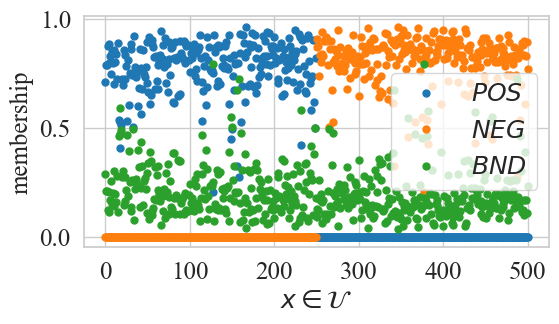

In [16]:
# lineplot all regions
# choose protected feature and region
plt.figure(figsize=(6, 3))
plt.plot(POS['POS'].loc[indices].values, 'tab:blue', label = "$POS$", linestyle = '',markersize = 5, marker='o')
plt.plot(NEG['NEG'].loc[indices].values, 'tab:orange', label = "$NEG$", linestyle = '',markersize = 5, marker='o')
plt.plot(BND['BND'].loc[indices].values, 'tab:green', label = "$BND$", linestyle = '',markersize = 5, marker='o')
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('$x \in \mathcal{U}$', fontsize=18)
plt.ylabel('membership', fontsize=18)
# plt.title('decision class low income $<50k$', fontsize=18)
filename = os.path.join(filepath, metadata['dataset_name']+'_'+str(seed)+'_thesis_regions_frvalues.pdf')
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\i'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\1369974142.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(BND_subset['Delta'].values, col, label="$\Delta f_{"+str(columns.get_loc(metadata[prot])+1)+"}$: "+cols_short[df.columns.get_loc(metadata[prot])])
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\1369974142.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(BND_subset['Delta'].values, col, label="$\Delta f_{"+str(columns.get_loc(metadata[prot])+1)+"}$: "+metadata[prot])
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\1369974142.py:23: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('$x \in \mathcal{U}$', fontsize=22)


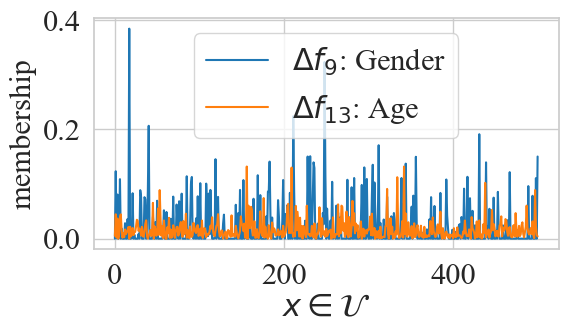

In [17]:
plt.figure(figsize=(6, 3))

# get columns without target
columns = df[[col for col in df.columns if col != metadata['target']]].columns

for prot, col in zip(['prot1', 'prot2'],['tab:blue', 'tab:orange']):

    BND_prot = pd.DataFrame([mem_dic[metadata[prot]][2][0],df.loc[:, metadata['target']]]).T # y_test.index
    BND_prot.columns = ['BND','Target']
    BND_prot.sort_values('Target', inplace = True)

    BND['Delta'] = np.abs(BND_prot['BND'].values - BND['BND'].values)
    BND_subset = BND.loc[indices,:].reset_index(drop=True)

    if metadata['dataset_name'] == 'German':
        plt.plot(BND_subset['Delta'].values, col, label="$\Delta f_{"+str(columns.get_loc(metadata[prot])+1)+"}$: "+cols_short[df.columns.get_loc(metadata[prot])])
    else:
        plt.plot(BND_subset['Delta'].values, col, label="$\Delta f_{"+str(columns.get_loc(metadata[prot])+1)+"}$: "+metadata[prot])

plt.legend(fontsize=22)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('$x \in \mathcal{U}$', fontsize=22)
plt.ylabel('membership', fontsize=22)
# plt.title('decision class creditworthy', fontsize=16) # low income $<50k$
filename = os.path.join(filepath, metadata['dataset_name']+'_bndprot_values.pdf')
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\3090655334.py:22: SyntaxWarning: invalid escape sequence '\D'
  ctitle = "$\Delta f_{"+str(df.columns.get_loc(metadata[prot])+1)+"}$: "+ metadata[prot] #cols_short[df.columns.get_loc(metadata[prot])]


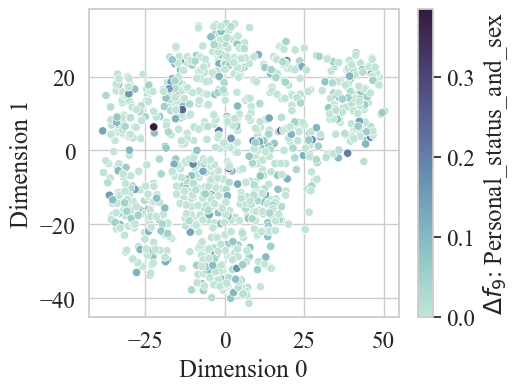

In [23]:
# load t-sne results
hpath = os.path.join(logpath,metadata['dataset_name']+'_perp30_tsne.csv')
dftsne = pd.read_csv(hpath, index_col=0)

# replace normalized age with original feature to make visualization more intuitive
if metadata['prot2'] == 'Age_in_years':
    df['Age_in_years'] = num['Age_in_years'].values

# change to 1 or 2
prot = 'prot1'
dm = dftsne # dftsne dfpca
dms = 'tsne' # 'tsne' 'pca'

if prot == 'prot1':
    dftsne['BND diff'] = BND_prot1['BND'] - BND['BND']
    # dfpca['BND diff'] = BND_prot1['BND'] - BND['BND']

if prot == 'prot2':
    dftsne['BND diff'] = BND_prot2['BND'] - BND['BND']
    # dfpca['BND diff'] = BND_prot2['BND'] - BND['BND']

ctitle = "$\Delta f_{"+str(df.columns.get_loc(metadata[prot])+1)+"}$: "+ metadata[prot] #cols_short[df.columns.get_loc(metadata[prot])] 

cmap= sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap= cmap, norm=colors.Normalize())
plt.figure(figsize=(5,4))
scatter = sns.scatterplot(data = dm, x = 'Dimension 0', y = 'Dimension 1', hue = 'BND diff', hue_norm= sm.norm, palette= cmap, legend= False);
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label(ctitle)

filename = os.path.join(filepath, metadata['dataset_name']+'_'+metadata[prot]+'_bnddiff_'+dms+'.pdf')
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')
plt.show()

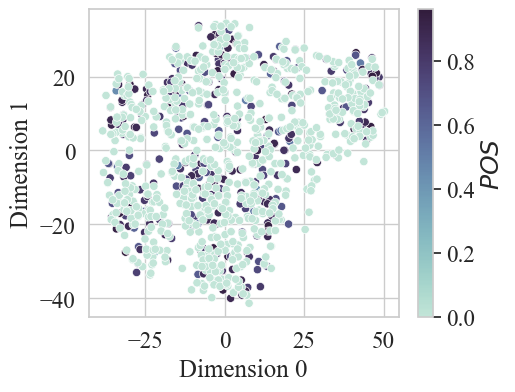

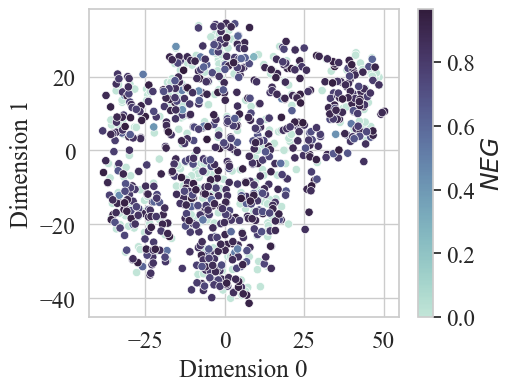

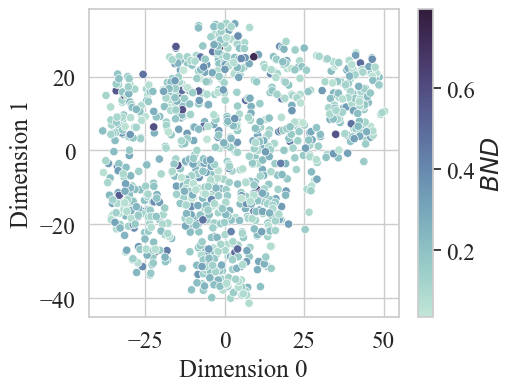

In [24]:
# change to 1 or 2
dm = dftsne # dftsne dfpca
dms = 'tsne' # 'tsne' 'pca'

dm['POS'] = POS['POS']
dm['NEG'] = NEG['NEG']
dm['BND'] = BND['BND']

for r in ['POS', 'NEG', 'BND']:

    ctitle = "$"+r+"$"

    cmap= sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
    sm = plt.cm.ScalarMappable(cmap= cmap, norm=colors.Normalize())
    plt.figure(figsize=(5,4))
    scatter = sns.scatterplot(data = dm, x = 'Dimension 0', y = 'Dimension 1', hue = r, hue_norm= sm.norm, palette= cmap, legend= False);
    cbar = plt.colorbar(sm, ax = plt.gca())
    cbar.set_label(ctitle)

    filename = os.path.join(filepath, metadata['dataset_name']+'_'+r+'_'+dms+'.pdf')
    plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')
    plt.show()

Barplot with results

In [28]:
mem_dic = {}
for root, folder, files in os.walk(logpath, topdown=False):
    if 'cv' in root[-5:]:
        mem_dic[root[-5:]] = {}
        for name in files:
            if 'pickle' in name:
                att_name = re.findall(r"(.*?)_mem.pickle", name)[0]
                file_path_name = os.path.join(root, name)

                # load membership values
                with open(file_path_name, 'rb') as handle: 
                    mem_dic_att = pickle.load(handle)
                    mem_dic[root[-5:]][att_name] = mem_dic_att

features = df[[col for col in df.columns if col != metadata['target']]].columns
results_raw = pd.DataFrame(index=features, columns=mem_dic.keys())

# compute FRU
for k in mem_dic.keys():
    for f in features:
        diff = mem_dic[k]['full'][-1][0] - mem_dic[k][f][-1][0]
        FRU = (sum(diff**2)/len(diff))**0.5
        results_raw.loc[f,k] = FRU

# normalize results
results_norm = results_raw / results_raw.sum(axis=0)

C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\73213124.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


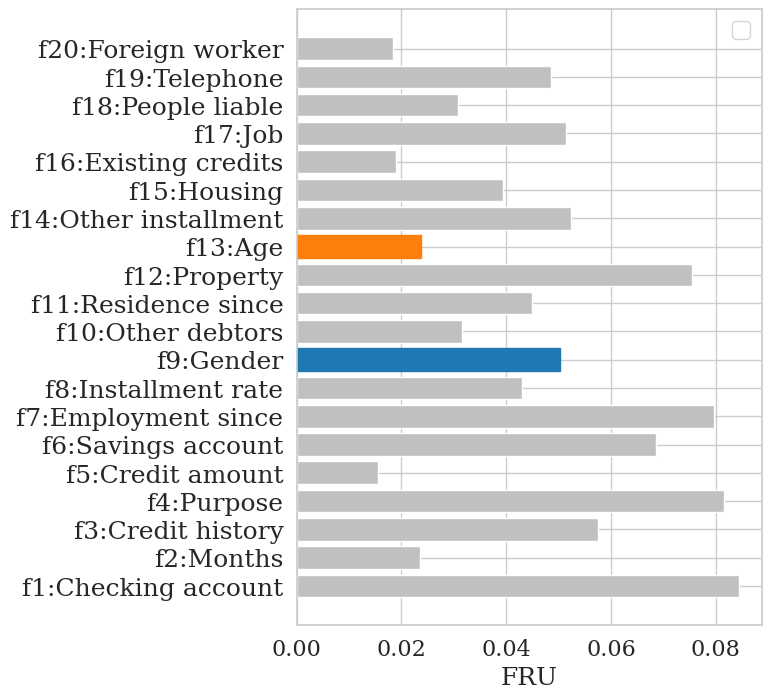

In [31]:
results = results_raw.reset_index()
results['Features'] = results.pop('index')

rcParams['font.family'] = 'serif'

# drop features to compute average
plot_fru = results.drop('Features', axis=1)

# compute average
mean_fru = plot_fru.mean(axis=1) 

# set index
if metadata['dataset_name'] == 'German':
    colnames_short = ['Checking account', 'Months', 'Credit history', 'Purpose', 'Credit amount', 'Savings account', 'Employment since', 'Installment rate', 'Gender', 'Other debtors', 
                      'Residence since', 'Property', 'Age', 'Other installment', 'Housing', 'Existing credits', 'Job', 'People liable', 'Telephone', 'Foreign worker']
    mean_fru.index = colnames_short
else:
    mean_fru.index = results['Features']

barWidth = 0.3
plt.figure(figsize=(6,8))

mean_fru.index = ['f'+str(1 + col)+':'+mean_fru.index[col] for col in range(len(mean_fru.index))]
barlist = plt.barh(np.arange(len(mean_fru)), mean_fru, xerr= plot_fru.std(axis=1), color = 'silver')
barlist[results[results['Features'] == metadata['prot1']].index.values[0]].set_color('tab:blue')
if metadata['prot2']:
    barlist[results[results['Features'] == metadata['prot2']].index.values[0]].set_color('tab:orange')

plt.yticks([r for r in range(len(mean_fru))], mean_fru.index, size = 18, rotation = 0)
plt.xticks(size = 16)
plt.xlabel('FRU', size = 18)
plt.legend()
plt.grid(visible=True)

filename = os.path.join(filepath, metadata['dataset_name']+'_ranking.jpg') # replace norm with raw or vice versa
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'jpg')
plt.show()

## 3. Compute group FRU & figures

In [32]:
# choose dataset
datasets = ['german.data', 'BROWARD_CLEAN.csv', 'titanic.csv', 'diabetes.csv', 'bank_r.csv',
            'adult.data', 'lawschool.csv', 'acsincome.pkl', 'acspubliccoverage.pkl', 
            'acsemployment.pkl']
dataset = 'german.data'

# load dataset
df, df_num, metadata, num, binarized_prot  = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

# choose features for which the FRU will be computed, all but the target feature
features = [col for col in df.columns if col != metadata['target']]

# create a folder name to save the membership values to the fuzzy rough regions
folder_name = metadata['dataset_name']+'_sample' # 
path = os.path.join(logpath, folder_name)
if not os.path.exists(path):
    os.makedirs(os.path.join(path))

In [ ]:
df, df_num, metadata, num, binarized_prot = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()
if len(df) > 10000:
    df = df.sample(10000, random_state=42)
features = [col for col in df.columns if col != metadata['target']]
folder_name = metadata['dataset_name']+'_sample_group' # 
path = os.path.join(logpath, folder_name)

for seed in random_states:
    print(seed)
    X = df[features]
    y = df[metadata['target']]
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

    df_test = deepcopy(X_test)
    df_test[metadata['target']] = y_test

    path_seed = os.path.join(path, 'test_cv'+str(seed))
    if not os.path.exists(path_seed):
        os.makedirs(os.path.join(path_seed))

    fairfru.FRU(df_test, path_seed, metadata['target']).membership_values(features)

In [35]:
import re
import pickle

# try:
#  metadata
# except NameError:
df, df_num, metadata, num, binarized_prot = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()
features = [col for col in df.columns if col != metadata['target']]
if len(df) > 10000:
    df = df.sample(n = 10000, random_state = 42)

case_name = metadata['dataset_name']+'_sample_group' # level1
path = os.path.join(logpath, case_name)

mem_dic = {}
for root, folder, files in os.walk(path, topdown=False):
    if 'test_cv' in root:
        mem_dic[root[-5:]] = {}
        for name in files:
            if 'pickle' in name:
                att_name = re.findall(r"(.*?)_mem.pickle", name)[0]
                file_path_name = os.path.join(root, name)

                # load membership values
                with open(file_path_name, 'rb') as handle: 
                    mem_dic_att = pickle.load(handle)
                    mem_dic[root[-5:]][att_name] = mem_dic_att

Rename groups for more meaningful interpretation

In [37]:
if metadata['dataset_name'] == 'titanic':
    df[metadata['prot2']] = df[metadata['prot2']].replace({1:'3rd class', 
                            0: '1st and 2nd classes', 0.5: '1st and 2nd classes'})
    
if metadata['dataset_name'] == 'lawschool':
    df[metadata['prot2']] = df[metadata['prot2']].replace({1:'male', 
                            0: 'female'})

if metadata['dataset_name'] == 'BROWARD_CLEAN':
    df[metadata['prot2']] = df[metadata['prot2']].replace({1:'female', 
                            0: 'male'})
    
if metadata['dataset_name'] == 'adult':
    df[metadata['prot1']] = df[metadata['prot1']].replace({1:'White', 
                            0: 'Black'})
    df[metadata['prot2']] = df[metadata['prot2']].replace({1:'male', 
                            0: 'female'})

if metadata['dataset_name'] == 'bank':
    df[metadata['prot2']] = binarized_prot.replace({1:'older than 30', 0: 'younger than 30'})
    df[metadata['prot1']] = df[metadata['prot1']].replace({1:'married', 0: 'single'})

if metadata['dataset_name'] == 'German':
    df[metadata['prot2']] = binarized_prot.replace({1:'older than 25', 0: 'younger or equal to 25'})

In [38]:
results = []

X = df[features]
y = df[metadata['target']]

for k in mem_dic.keys():
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
    for f in ['prot1', 'prot2']:        
        diff = pd.DataFrame(mem_dic[k]['full'][-1][0] - mem_dic[k][metadata[f]][-1][0], columns=['Delta'])
        diff[metadata[f]] = X_test[metadata[f]].values
        for group in X_test[metadata[f]].unique():
            group_diff = diff[diff[metadata[f]] == group]
            group_FRU = ((group_diff['Delta']**2).sum()/len(group_diff))**0.5  
            results.append([group_FRU, group, metadata[f], k])

results = pd.DataFrame(results, columns=['group FRU', 'Group', 'Sensitive feature', 'Sample'])

In [39]:
# one sensitive feature (diabetes dataset)

# set multi-index
results_raw = results.groupby(['Sample', 'Group', 'Sensitive feature'])['group FRU'].first()

# normalize group fru values
results_norm = results_raw / results.groupby(['Sample', 'Sensitive feature'])['group FRU'].sum()

# create table to store raw and normalized group fru values
results_table = pd.DataFrame(index=np.sort(results['Group'].unique()), columns=['Raw', 'Normalized'])

results_table['Raw'] = results_raw.groupby('Group').mean().round(3).astype('str') + ' $(\\pm' + results_raw.groupby('Group').std().round(3).astype('str') + ')$' 
results_table['Normalized'] = results_norm.groupby('Group').mean().round(3).astype('str') + ' $(\\pm' + results_norm.groupby('Group').std().round(3).astype('str') + ')$' 
print(results_table.to_latex())

\begin{tabular}{lll}
\toprule
 & Raw & Normalized \\
\midrule
female & 0.047 $(\pm0.009)$ & 0.531 $(\pm0.045)$ \\
male & 0.041 $(\pm0.006)$ & 0.469 $(\pm0.045)$ \\
older than 25 & 0.019 $(\pm0.004)$ & 0.493 $(\pm0.051)$ \\
younger or equal to 25 & 0.019 $(\pm0.003)$ & 0.507 $(\pm0.051)$ \\
\bottomrule
\end{tabular}



In [40]:
prot = 'prot1'
results_norm_diff = results_raw.reset_index()
results_norm_diff = results_norm_diff[results_norm_diff['Sensitive feature'] == metadata[prot]]
group_diff = abs(results_norm_diff[results_norm_diff['Group'] == results_norm_diff['Group'].unique()[0]]['group FRU'].values - results_norm_diff[results_norm_diff['Group'] == results_norm_diff['Group'].unique()[1]]['group FRU'].values) # metadata['priv_group_'+metadata[prot]], 
print(metadata[prot], 'raw mean', group_diff.mean().round(3), 'std', group_diff.std().round(3))

Personal_status_and_sex raw mean 0.007 std 0.007


## 4. Individual literature measures

In [43]:
dataset = 'german.data' #'german.data', 'BROWARD_CLEAN.csv','titanic.csv','adult.data', 'bank_r.csv'
df, df_num, metadata, _, binarized_prot  = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()
features = [col for col in df.columns if col != metadata['target']]
features_num = [col for col in df_num.columns if col != metadata['target']]

colnames_short = ['Checking account', 'Months', 'Credit history', 'Purpose', 'Credit amount', 'Savings account', 'Employment since', 'Installment rate', 'Gender', 'Other debtors', 
                      'Residence since', 'Property', 'Age', 'Other installment', 'Housing', 'Existing credits', 'Job', 'People liable', 'Telephone', 'Foreign worker']

In [44]:
from itertools import combinations
from matplotlib.offsetbox import AnchoredText
from aif360.sklearn.metrics import consistency_score, generalized_entropy_error

In [45]:
consistency = []
ge = []
for seed in random_states:
    print(seed)
    df, df_num, metadata, _, _ = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

    if len(df) > 10000:
        df_sample = df.sample(n = 10000, random_state = seed) # 3000 for larger datasets
        X = df_num.sample(n = 10000, random_state = seed) # 3000 for larger datasets
    else:
        df_sample = df.sample(n = len(df), random_state = seed)
        X = df_num.sample(n = len(df), random_state = seed)

    y_test, y_pred, X_test = train_classifier_predict(X,metadata,seed=42,predict=True)
    consistency.append([seed, 'full', consistency_score(X_test, y_test).round(3)])
    ge.append([seed, 'full', generalized_entropy_error(y_test, y_pred, pos_label=metadata['pos_label']).round(3)])

    for f in features:
        r_features = deepcopy(features_num)
        for f_num in features_num:
            if f in f_num:
                r_features.remove(f_num)
        r_features.append(metadata['target'])
        y_test, y_pred, X_test = train_classifier_predict(X[r_features],metadata,seed=42,predict=True)
        consistency.append([seed, f, consistency_score(X_test, y_test).round(3)])
        ge.append([seed, f, generalized_entropy_error(y_test, y_pred, pos_label=metadata['pos_label']).round(3)])

con_results = pd.DataFrame(consistency, columns=['cv','feature','con'])
con_results.to_csv(os.path.join(logpath, 'consistency.csv'))

gee_results = pd.DataFrame(ge, columns=['cv','feature','ge'])
gee_results.to_csv(os.path.join(logpath, 'ge.csv'))

102
435
860
270
106


In [48]:
import re
import pickle

df, df_num, metadata, _, binarized_prot = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

case_name = metadata['dataset_name']+'_sample'
path = os.path.join(logpath, case_name)

mem_dic = {}
for root, folder, files in os.walk(path, topdown=False):
    if ('cv' in root[-5:]) and ('test' not in root):
        mem_dic[root[-5:]] = {}
        for name in files:
            if 'pickle' in name:
                att_name = re.findall(r"(.*?)_mem.pickle", name)[0]
                file_path_name = os.path.join(root, name)

                # load membership values
                with open(file_path_name, 'rb') as handle: 
                    mem_dic_att = pickle.load(handle)
                    mem_dic[root[-5:]][att_name] = mem_dic_att

features = df[[col for col in df.columns if col != metadata['target']]].columns
results_raw = pd.DataFrame(index=features, columns=mem_dic.keys())

# compute FRU
for k in mem_dic.keys():
    for f in features:
        diff = mem_dic[k]['full'][-1][0] - mem_dic[k][f][-1][0]
        FRU = (sum(diff**2)/len(diff))**0.5
        results_raw.loc[f,k] = FRU

# normalize results
results_norm = results_raw / results_raw.sum(axis=0)

In [49]:
con_results = pd.read_csv(os.path.join(logpath, 'consistency.csv'),index_col=0)
gee_results = pd.read_csv(os.path.join(logpath, 'ge.csv'),index_col=0)

con_results = con_results[con_results['feature'] != 'full']
gee_results = gee_results[gee_results['feature'] != 'full']

con_results['Measure'] = len(con_results)*['CON $F/(f_i)$']
gee_results['Measure'] = len(gee_results)*['GEI $F/(f_i)$']

con_results['value'] = con_results.pop('con')
gee_results['value'] = gee_results.pop('ge')

r = results_raw.reset_index()
r = pd.wide_to_long(r, stubnames='cv', i='index', j='fold')
r.columns = ['value']
r = r.reset_index()
r.columns = ['feature', 'cv', 'value']
r['Measure'] = len(r)*['$\Omega_{k}(f_i)$ (FRU)']


all = pd.concat([r,con_results[r.columns],gee_results[r.columns]])


fru = r.groupby(['feature'],sort=False)['value'].mean()
fru_std = r.groupby(['feature'],sort=False)['value'].std()

ge = gee_results.groupby(['feature'],sort=False)['value'].mean()
ge_std = gee_results.groupby(['feature'],sort=False)['value'].std()

con = con_results.groupby(['feature'],sort=False)['value'].mean()
con_std = gee_results.groupby(['feature'],sort=False)['value'].std()

name_dic_polar = {'fru': '$\Omega_{k}(f_i)$ (FRU)',
            'ge':'GEI $F/(f_i)$',
            'con':'CON $F/(f_i)$'}

<>:18: SyntaxWarning: invalid escape sequence '\O'
<>:33: SyntaxWarning: invalid escape sequence '\O'
<>:18: SyntaxWarning: invalid escape sequence '\O'
<>:33: SyntaxWarning: invalid escape sequence '\O'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\324253930.py:18: SyntaxWarning: invalid escape sequence '\O'
  r['Measure'] = len(r)*['$\Omega_{k}(f_i)$ (FRU)']
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\324253930.py:33: SyntaxWarning: invalid escape sequence '\O'
  name_dic_polar = {'fru': '$\Omega_{k}(f_i)$ (FRU)',


C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2985415020.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=[i.get_text() if (ind+1)%2 else '' for i,ind in zip(ax.get_yticklabels(), range(len(ax.get_yticklabels())))])


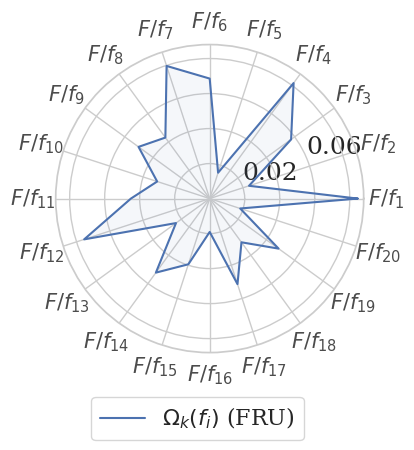

C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2985415020.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=[i.get_text() if (ind+1)%2 else '' for i,ind in zip(ax.get_yticklabels(), range(len(ax.get_yticklabels())))])


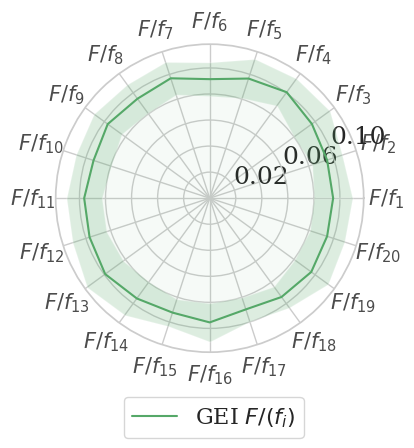

C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2985415020.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels=[i.get_text() if (ind+1)%2 else '' for i,ind in zip(ax.get_yticklabels(), range(len(ax.get_yticklabels())))])


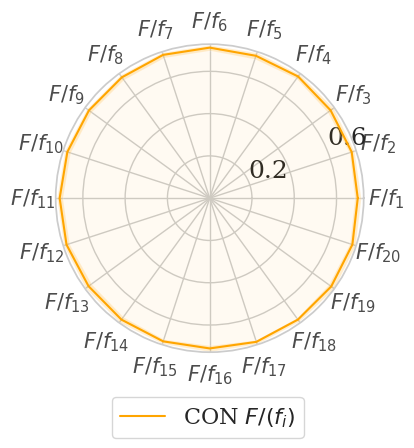

In [51]:
for ave, std, n, c in zip([fru, ge, con], [fru_std, ge_std, con_std], ['fru', 'ge', 'con'], ['b', 'g', 'orange']):

    plt.figure(figsize=(4, 4))
    plt.subplot(polar=True)
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(ave)+1)
    plt.plot(label_loc, list(ave) + [list(ave)[0]], label=name_dic_polar[n], color = c) # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed', 
    plt.fill(label_loc, list(ave) + [list(ave)[0]], c, alpha=0.05)

    upper = [*list(ave+std), list(ave)[0]+list(std)[0]]
    lower = [*list(ave-std), list(ave)[0]-list(std)[0]]
    plt.fill_between(label_loc, upper, lower, facecolor=c, alpha=0.2)

    labs= [r'$F/{f_{'+str(f+1)+r'}}$' for f in range(len(features))]# ['f'+str(i) for i in range(1,len(ge)+1)]
    lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=labs, color=(0.0, 0.0, 0.0, 0.7), fontsize=15)
    plt.legend(bbox_to_anchor = (0.95,0), borderaxespad = 2, fontsize=16, ncol = 3, columnspacing = 0.5)
    ax = plt.gca()
    ax.set_yticklabels(labels=[i.get_text() if (ind+1)%2 else '' for i,ind in zip(ax.get_yticklabels(), range(len(ax.get_yticklabels())))])
    plt.setp(ax.get_yticklabels(), fontsize=18)
    filename = os.path.join(filepath, metadata['dataset_name']+'_ranking_'+n+'.pdf') # replace norm with raw or vice versa
    plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')
    plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\585955750.py:2: SyntaxWarning: invalid escape sequence '\O'
  all_corr['$\Omega_{k}(f_i)$ (FRU)'] = all_corr.pop('value')
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\585955750.py:10: SyntaxWarning: invalid escape sequence '\O'
  name_dic = {'$\Omega_{k}(f_i)$ (FRU)': 'FRU',


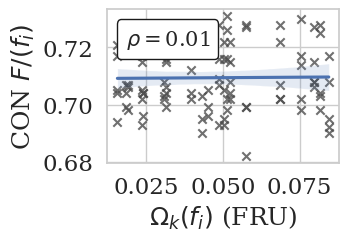

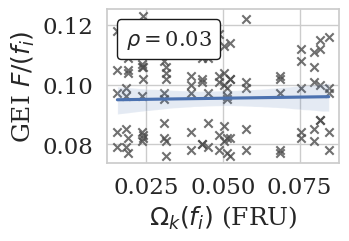

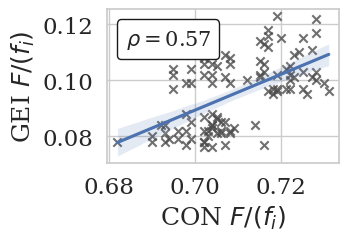

In [52]:
all_corr = deepcopy(r)
all_corr['$\Omega_{k}(f_i)$ (FRU)'] = all_corr.pop('value')
all_corr['CON $F/(f_i)$'] = con_results.reset_index()['value']
all_corr['GEI $F/(f_i)$'] = gee_results.reset_index()['value']

m_corr = all_corr[all_corr.columns[-3:]].corr().round(2)

table=all_corr[all_corr.columns[-3:]].astype('float')

name_dic = {'$\Omega_{k}(f_i)$ (FRU)': 'FRU',
            'CON $F/(f_i)$': 'CON',
            'GEI $F/(f_i)$': 'GEI'}

for x, y in list(combinations(m_corr.columns,2)):
    fig, g = plt.subplots(figsize=(3, 2))
    g = sns.regplot(table, x=x, y=y, marker="x", color=".3", line_kws=dict(color="b"))
    # g.text(0.02,0.06,'$\\rho=$'+str(m_corr.loc[x,y]),bbox=dict(boxstyle="square,pad=0.16", fc="lightblue"))
    at = AnchoredText('$\\rho=$'+str(m_corr.loc[x,y]),
                      prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    g.add_artist(at)
    filename = os.path.join(filepath, metadata['dataset_name']+'_metric_corr'+name_dic[x]+'_'+name_dic[y]+".pdf") # replace norm with raw or vice versa
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [54]:
con_results = pd.read_csv(os.path.join(logpath, 'consistency.csv'),index_col=0)
gee_results = pd.read_csv(os.path.join(logpath, 'ge.csv'),index_col=0)

folds_con = pd.DataFrame()

for seed in random_states:
    fold = con_results[(con_results['cv'] == seed)].reset_index(drop=True)
    fold_trans = fold.T
    full = fold_trans.pop(0)
    fold = fold_trans.T
    fold['value'] = abs(full['con'] - fold['con'].values)
    folds_con = pd.concat([folds_con,fold])
folds_con['Measure'] = len(folds_con)*['$\Delta$ CON $(f_i)$']

folds_ge = pd.DataFrame()

for seed in random_states:
    fold = gee_results[(gee_results['cv'] == seed)].reset_index(drop=True)
    fold_trans = fold.T
    full = fold_trans.pop(0)
    fold = fold_trans.T
    fold['value'] = abs(full['ge'] - fold['ge'].values)
    folds_ge = pd.concat([folds_ge,fold])
folds_ge['Measure'] = len(folds_ge)*['$\Delta$ GEI $(f_i)$']

r = results_raw.reset_index()
r = pd.wide_to_long(r, stubnames='cv', i='index', j='fold')
r.columns = ['value']
r = r.reset_index()
r.columns = ['feature', 'cv', 'value']
r['Measure'] = len(r)*['$\Omega_{k}(f_i)$ (FRU)']


all = pd.concat([r,folds_con[r.columns],folds_ge[r.columns]])
all

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\O'
<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\O'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2613565602.py:13: SyntaxWarning: invalid escape sequence '\D'
  folds_con['Measure'] = len(folds_con)*['$\Delta$ CON $(f_i)$']
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2613565602.py:24: SyntaxWarning: invalid escape sequence '\D'
  folds_ge['Measure'] = len(folds_ge)*['$\Delta$ GEI $(f_i)$']
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\2613565602.py:31: SyntaxWarning: invalid escape sequence '\O'
  r['Measure'] = len(r)*['$\Omega_{k}(f_i)$ (FRU)']


,feature,cv,value,Measure
0,Status_of_existing_checking_account,102,0.084534,$\Omega_{k}(f_i)$ (FRU)
1,Duration_in_month,102,0.023632,$\Omega_{k}(f_i)$ (FRU)
2,Credit_history,102,0.057492,$\Omega_{k}(f_i)$ (FRU)
3,Purpose,102,0.08156,$\Omega_{k}(f_i)$ (FRU)
4,Credit_amount,102,0.015542,$\Omega_{k}(f_i)$ (FRU)
...,...,...,...,...
16,Number_of_existing_credits_at_this_bank,106,0.003,$\Delta$ GEI $(f_i)$
17,Job,106,0.003,$\Delta$ GEI $(f_i)$
18,Number_of_people_being_liable_to_provide_maint...,106,0.003,$\Delta$ GEI $(f_i)$
19,Telephone,106,0.004,$\Delta$ GEI $(f_i)$


In [55]:
fru = r.groupby(['feature'],sort=False)['value'].mean()
fru_std = r.groupby(['feature'],sort=False)['value'].std()

ge = folds_ge.groupby(['feature'],sort=False)['value'].mean()
ge_std = folds_ge.groupby(['feature'],sort=False)['value'].std()

con = folds_con.groupby(['feature'],sort=False)['value'].mean()
con_std = folds_con.groupby(['feature'],sort=False)['value'].std()

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\233262095.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(label_loc, list(ge) + [list(ge)[0]], label='$\Delta$ GEI $(f_i)$', color = 'g') # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed',
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\233262095.py:10: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(label_loc, list(fru) + [list(fru)[0]], label='$\Omega_{k}(f_i)$ (FRU)', color = 'b') # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed',
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\233262095.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(label_loc, list(con) + [list(con

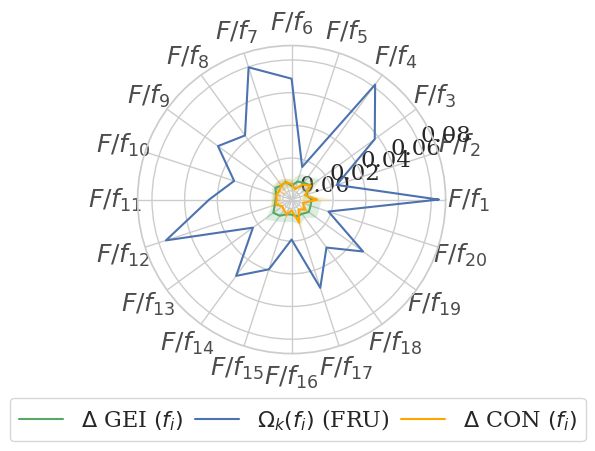

In [57]:
plt.figure(figsize=(4, 4))
plt.subplot(polar=True)
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(ge)+1)
plt.plot(label_loc, list(ge) + [list(ge)[0]], label='$\Delta$ GEI $(f_i)$', color = 'g') # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed', 

upper = [*list(ge+ge_std), list(ge)[0]+list(ge_std)[0]]
lower = [*list(ge-ge_std), list(ge)[0]-list(ge_std)[0]]
plt.fill_between(label_loc, upper, lower, facecolor='g', alpha=0.2)

plt.plot(label_loc, list(fru) + [list(fru)[0]], label='$\Omega_{k}(f_i)$ (FRU)', color = 'b') # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed', 

upper = [*list(fru+fru_std), list(fru)[0]+list(fru_std)[0]]
lower = [*list(fru-fru_std), list(fru)[0]-list(fru_std)[0]]
plt.fill_between(label_loc, upper, lower, facecolor='b', alpha=0.2)

plt.plot(label_loc, list(con) + [list(con)[0]], label='$\Delta$ CON $(f_i)$', color = 'orange') # $\Delta$CON$(f_i)$, $\Omega$($f_i)$, linestyle = 'dashed', 

upper = [*list(con+con_std), list(con)[0]+list(con_std)[0]]
lower = [*list(con-con_std), list(con)[0]-list(con_std)[0]]
plt.fill_between(label_loc, upper, lower, facecolor='orange', alpha=0.2)

labs= [r'$F/{f_{'+str(f+1)+r'}}$' for f in range(len(features))]# ['f'+str(i) for i in range(1,len(ge)+1)]
lines, labels = plt.thetagrids(np.degrees(label_loc[:-1]), labels=labs, color=(0.0, 0.0, 0.0, 0.7), fontsize=18)
plt.legend(bbox_to_anchor = (1.6,0), borderaxespad = 2, fontsize=16, ncol = 3, columnspacing = 0.5)
filename = os.path.join(filepath, metadata['dataset_name']+'_ranking_individual_fairness.pdf') # replace norm with raw or vice versa
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')
plt.show()

## 5. Group Fairness Measures

In [61]:
np.random.seed(42)
random_states = np.random.randint(0,1000,5)

dataset = 'german.data'
df, df_num, metadata, num, binarized_prot = preprocess_datasets(dataset, path=dataset_path).preprocess_dataset()

In [63]:
group_fairness_results = []
for prot in ['prot1', 'prot2']:
    for seed in random_states:
        if ('pclass' in metadata[prot].lower()) or ('age' in metadata[prot].lower()):
            # use discretized protected numeric feature
            df[metadata[prot]] = binarized_prot.values.astype('object')
            df_num[metadata[prot]] = binarized_prot.values.astype('object')

        if metadata['dataset_name'] == 'lawschool':
            df[metadata['R']] = binarized_prot.values
            
        if metadata['dataset_name'] == 'diabetes':
            df[metadata['R']] = binarized_prot.values
        
        if len(df) > 10000:
            X = df_num.sample(10000,random_state=42)
        else:
            X = df_num

        y_test, y_pred, _ = train_classifier_predict(X, metadata, seed, predict = True)
        y_test_indices = y_test.index

        y_test = pd.DataFrame(y_test.values, index=df.loc[y_test_indices,metadata[prot]].values, columns=[metadata['target']])
        y_test.index.name = metadata[prot]

        df_ypred = df.loc[y_test_indices]
        df_ypred[metadata['target']] = y_pred
        y_pred = pd.DataFrame(y_pred, index=df.loc[y_test_indices,metadata[prot]].values, columns=[metadata['target']])
        y_pred.index.name = metadata[prot]

        # grount truth measure on test set
        SP_GT = statistical_parity_difference(y_test, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]]).round(2)
        
        # the diabetes dataset has more than two groups in the sensitive feature, measure cannot handle that, so two groups are selected
        if metadata['dataset_name'] == 'diabetes':
            y_test_prot = y_test.reset_index()
            y_test_prot= y_test_prot[(y_test_prot['race'] == metadata['priv_group_race']) | (y_test_prot['race'] == metadata['unpriv_group_race'])]
            y_test_prot.set_index('race', drop=True, inplace=True)
        else:
            y_test_prot = y_test
        KL_GT =  kl_divergence(y_test_prot, prot_attr=metadata[prot], priv_group=metadata['priv_group_'+metadata[prot]])
        DI_GT =  disparate_impact_ratio(y_test, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]])
        if not metadata['R']: # applies to titanic dataset where there is no explainable feature
            CDD_GT = 'NaN'
            CDD = 'NaN'
        else:
            CDD_GT =  np.round(CDD_difference(df.loc[y_test_indices],metadata,metadata[prot]),2)
            CDD = np.round(CDD_difference(df_ypred, metadata, metadata[prot]),2)

        # predictions measures
        SP = np.round(statistical_parity_difference(y_pred, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]]),2)
        
        # the diabetes dataset has more than two groups in the sensitive feature, measure cannot handle that, so two groups are selected
        if metadata['dataset_name'] == 'diabetes':
            y_pred_prot = y_pred.reset_index()
            y_pred_prot= y_pred_prot[(y_pred_prot['race'] == metadata['priv_group_race']) | (y_pred_prot['race'] == metadata['unpriv_group_race'])]
            y_pred_prot.set_index('race', drop=True, inplace=True)
        else:
            y_pred_prot = y_test
        KL = np.round(kl_divergence(y_pred_prot, prot_attr=metadata[prot], priv_group=metadata['priv_group_'+metadata[prot]]),2)
        DI = np.round(disparate_impact_ratio(y_pred, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]]),2)
        EO = np.round(equal_opportunity_difference(y_test, y_pred, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]]),2)
        AO = np.round(average_odds_difference(y_test, y_pred, prot_attr=metadata[prot],pos_label=0,priv_group=metadata['priv_group_'+metadata[prot]]),2)

        group_fairness_results.append([metadata[prot], seed, SP_GT, KL_GT, DI_GT, CDD_GT, SP, KL, DI, EO, AO, CDD])

group_fair_results = pd.DataFrame(group_fairness_results,
             columns=['Protected', 'Fold', 'SP_GT', 'KL_GT', 'DI_GT', 'CDD_GT', 'SP', 'KL', 'DI', 'EO', 'AO', 'CDD'])

case_name = metadata['dataset_name']+'_sample' # 
filepath_tosave = os.path.join(logpath, case_name, metadata['dataset_name']+'_FRU_group_baseline_results.xlsx')
group_fair_results.to_excel(filepath_tosave, index=None)

In [65]:
table = group_fair_results.groupby(['Protected'])[['SP', 'KL', 'EO', 'AO', 'CDD']].mean().round(3).abs().astype('str') + ' ($\\pm' + group_fair_results.groupby(['Protected'])[['SP', 'KL', 'EO', 'AO', 'CDD']].std().round(3).astype('str') + '$)'
table.columns = ['$\Delta\\text{PP}$', 'KL-divergence', '$\Delta\\text{EO}$', '$\Delta\\text{AO}$', '$\Delta\\text{CDD}$']

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\794692431.py:2: SyntaxWarning: invalid escape sequence '\D'
  table.columns = ['$\Delta\\text{PP}$', 'KL-divergence', '$\Delta\\text{EO}$', '$\Delta\\text{AO}$', '$\Delta\\text{CDD}$']
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\794692431.py:2: SyntaxWarning: invalid escape sequence '\D'
  table.columns = ['$\Delta\\text{PP}$', 'KL-divergence', '$\Delta\\text{EO}$', '$\Delta\\text{AO}$', '$\Delta\\text{CDD}$']
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_18444\794692431.py:2: SyntaxWarning: invalid escape sequence '\D'
  table.

In [66]:
print(table.T.to_latex())

\begin{tabular}{lll}
\toprule
Protected & Age_in_years & Personal_status_and_sex \\
\midrule
$\Delta\text{PP}$ & 0.138 ($\pm0.099$) & 0.066 ($\pm0.011$) \\
KL-divergence & 0.046 ($\pm0.048$) & 0.02 ($\pm0.02$) \\
$\Delta\text{EO}$ & 0.076 ($\pm0.145$) & 0.076 ($\pm0.094$) \\
$\Delta\text{AO}$ & 0.094 ($\pm0.113$) & 0.054 ($\pm0.04$) \\
$\Delta\text{CDD}$ & 0.168 ($\pm0.079$) & 0.092 ($\pm0.028$) \\
\bottomrule
\end{tabular}



## 6. Hyperparameter optimization

In [4]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import re
import pickle

A sample of the datasets is used here to save time.

In [13]:
df, _, metadata, _, _ = preprocess_datasets('german.data', path=dataset_path).preprocess_dataset()
if len(df) > 100:
    df = df.sample(100, random_state=1).reset_index(drop=True)
folder_name = metadata['dataset_name']+'_'+'hpo' # 
path = os.path.join(logpath, folder_name)
features = [col for col in df.columns if col != metadata['target']]
features2 = deepcopy(features)
features2.append('full')

In [14]:
# 2hours to run
methods = ['HMOM','HEOM','HVDM']
implicators = ['Lukasiewicz']
for method in methods:
    print(method, end=', ')
    for im in implicators:
        print(im, end=', ')
        for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            path2 = os.path.join(path, method, im, 'alpha_'+str(alpha))
            if not os.path.exists(path2):
                os.makedirs(os.path.join(path2))
            print(alpha, end=', ')          
            fairfru.FRU(df, path2, metadata['target'],alpha=alpha).membership_values(features, hide_progress = True)

HEOM, Lukasiewicz, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 

In [15]:
methods = ['HEOM', 'HMOM','HVDM']
implicators = ['Lukasiewicz']
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# load membership values
m_dic = {}
for method in methods:
    m_dic[method] = {}
    for im in implicators:
        m_dic[method][im] = {}
        for alpha in alphas:
            m_dic[method][im][alpha] = pd.DataFrame()
            for f in features2:
                path2 = os.path.join(path, method, im, 'alpha_'+str(alpha), f+'_mem.pickle')
                POS, NEG, BND = pd.read_pickle(path2)
                m_dic[method][im][alpha][f] = BND[0]

# load and compute FRU values
fru_dic = []
for method in methods:
    for im in implicators:
        for alpha in alphas:

            # load membership values computed using all features
            pathfull = os.path.join(path, method, im, 'alpha_'+str(alpha), 'full_mem.pickle')
            POS, NEG, BND = pd.read_pickle(pathfull)
            for f in features:
                
                # load membership values computed after suppressing feature f
                path2 = os.path.join(logpath, folder_name, method, im, 'alpha_'+str(alpha), f+'_mem.pickle')
                POS_f, NEG_f, BND_f = pd.read_pickle(path2)
                fru = (sum((BND_f[0] - BND[0])**2)/len(df))**0.5
                fru_dic.append([method, im, alpha, f, fru])

df = pd.DataFrame(fru_dic, columns=['Distance', 'Implication', 'Alpha', 'Feature', 'FRU'])

C:\Users\lucp11124\AppData\Local\Temp\ipykernel_21716\3940699622.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


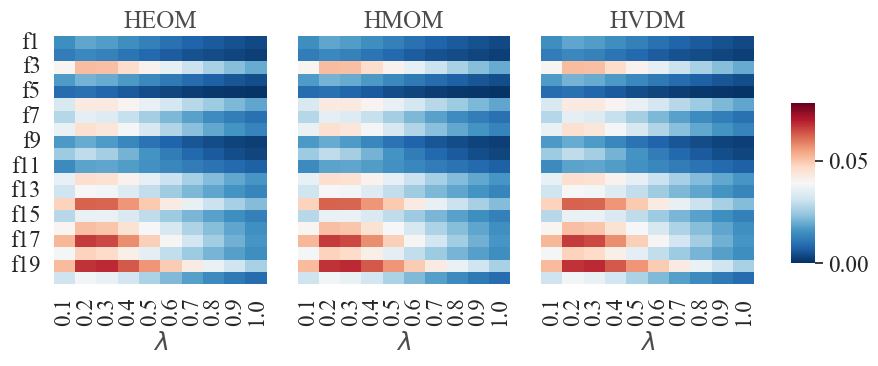

In [20]:
# restructure data before plotting heatmap
dataframes = {}
for d in df['Distance'].unique():
  df_heat = df[(df['Distance'] == d) 
  & (df['Implication'] == 'Lukasiewicz')
  & (df['Feature'])].pivot(index="Feature",columns="Alpha", values="FRU") # 'Creditworthiness'
  df_heat.index = ['f'+str(i) for i in range(1,len(df_heat.index)+1)]
  dataframes[d] = df_heat

# set ytick labels
xticklab = ["0.1"  , "0.2"  , "0.3"  , "0.4"  , "0.5"  , "0.6"  , "0.7"  , "0.8"  , "0.9", "1.0"]
xtick = ['HEOM', 'HMOM', 'HVDM']

yticklab = ['f'+str(i) if i%2 else None for i in range(1,len(df_heat.index)+1)]

fig, axn = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,4))
cbar_ax = fig.add_axes([1.01, .3, .03, .4])
m = max(dataframes['HMOM'].max(axis=1).max()+0.01, dataframes['HMOM'].max(axis=1).max()+0.01) # the one for HMOM

show = 1
for (i, ax), data in zip(enumerate(axn.flat),dataframes):
    sns.heatmap(dataframes[data], ax=ax,
                cbar=i == 0, vmin=0, vmax=m,
                cbar_ax=None if i else cbar_ax, xticklabels=xticklab, yticklabels= yticklab,
                cmap='RdBu_r')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for label in ax.get_yticklabels():
        label.set_rotation(0)

for ax, col in zip(axn, xtick):
    ax.set_title(col,color=(0.0, 0.0, 0.0, 0.7), fontsize=18)

for ax, row in zip(axn, ['$\\lambda$', '$\\lambda$', '$\\lambda$']):
    ax.set_xlabel(row,  color=(0.0, 0.0, 0.0, 0.7), fontsize=18) # size='large'

fig.autofmt_xdate(rotation=45)
 
plt.tight_layout()
# plt.savefig(os.path.join(filepath,metadata['dataset_name']+'_'+dist+'_hpo_heatmap.pdf'), bbox_inches = 'tight', dpi=700)